In [1]:
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
import pickle
plt.style.use('./greygrid.mplstyle')
plt.rcParams["figure.figsize"] = (8,6)

In [4]:
%run ../code/data_proc.py
test_data = read_cdph_test()

In [2]:
def proc_daily_df(hdt_daily):
    """
    argument: pd.Dataframe indexed by date, with 'positive' and 'negative' columns
    """
    hdt_daily['total'] = hdt_daily.eval('positive + negative')
    hdt_daily = hdt_daily.join(hdt_daily.rolling('7D').mean(),rsuffix='_7dav')
    hdt_daily['pos_rate'] = hdt_daily.eval('positive / (positive + negative)')
    hdt_daily['pos_rate_7dav'] = hdt_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')
    return hdt_daily

In [5]:
test_data = test_data.groupby(['lab_result_date','county','FIPS']).sum()

In [6]:
test_data = test_data.reset_index()

In [7]:
test_data['county'] = test_data['county'].str.title()

In [8]:
CA_data = test_data[test_data['county'] != 'Yolo']

In [9]:
CA_data = CA_data.rename(columns={'lab_result_date': 'date', 
                                  'pos_results': 'positive', 
                                  'neg_results': 'negative'})

In [10]:
CA_data = CA_data.groupby('date').sum()[['positive', 'negative']]

In [11]:
hdt_data = pd.read_csv('../data/DeloitteWeekly_v3_LJS_04182021.csv')

In [12]:
geo_nas = hdt_data['CensusGEOID'].isna()
hdt_data.loc[~geo_nas,'CensusGEOID'] = hdt_data.loc[~geo_nas,'CensusGEOID'].astype(int).astype(str).str.zfill(15)
hdt_data['CollectionDateTime'] = pd.to_datetime(hdt_data['CollectionDateTime'])

hdt_data['age_range'] = pd.cut(hdt_data['age'],
       [0,18,25,35,45,55,65,75,85,200],
       right = False,
       labels=['0-17','18-24','25-34','35-44','45-54','55-64','65-74','75-84','85+'])

hdt_data.loc[~geo_nas,'CBG'] = hdt_data.loc[~geo_nas,'CensusGEOID'].str[:-3]

In [13]:
latest_date = hdt_data['CollectionDateTime'].dt.date.max()

In [14]:
latest_date

datetime.date(2021, 4, 18)

In [307]:
date_idx = pd.period_range('2020-12-1',latest_date,freq='D')

In [324]:
CA_data.index = pd.PeriodIndex(CA_data.index,freq='d')

In [325]:
CA_daily = proc_daily_df(CA_data.reindex(date_idx))

In [328]:
small_date_idx = pd.period_range('2021-1-1',latest_date)

In [331]:
CA_daily = CA_daily.reindex(small_date_idx)

In [332]:
cbg = pd.read_excel('../data/CBGInformation.xlsx', dtype={'CBG_cod':str})

In [333]:
cbg = cbg.rename(columns = {'CBG_cod':'CBG'})

In [334]:
cbg['CBG'] = cbg['CBG'].str.zfill(12)

In [335]:
davis_cbgs = list(cbg.loc[cbg['City']=='Davis', 'CBG'])

In [336]:
confirmed_davis = hdt_data['CBG'].isin(davis_cbgs) | yolo_data['patient_zip'].str[:5].isin(['95616','95618'])

In [337]:
davis_data = hdt_data[confirmed_davis]

In [338]:
yolo_data = hdt_data[~hdt_data['CBG'].isin(davis_cbgs)]

In [339]:
yolo_data = hdt_data[(hdt_data['County'] == 'Yolo') & ~ confirmed_davis]

In [340]:
davis_data['positive'] = davis_data['Result'] == 'Detected'
davis_data['negative'] = davis_data['Result'] == 'Not Detected'
yolo_data['positive'] = yolo_data['Result'] == 'Detected'
yolo_data['negative'] = yolo_data['Result'] == 'Not Detected'

<ipython-input-340-61da7f813b39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-340-61da7f813b39>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-340-61da7f813b39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-340-61da7f813

In [341]:
davis_data['Date'] = pd.PeriodIndex(davis_data['CollectionDateTime'], freq='D')
yolo_data['Date'] = pd.PeriodIndex(yolo_data['CollectionDateTime'], freq='D')

<ipython-input-341-a817f4656412>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-341-a817f4656412>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [374]:
davis_large = davis_data.groupby('Date').sum()[['positive','negative']]

In [376]:
davis_large = proc_daily_df(davis_large)

In [401]:
davis_large.reset_index().to_csv('../data/davis_tpp.csv',index=False)

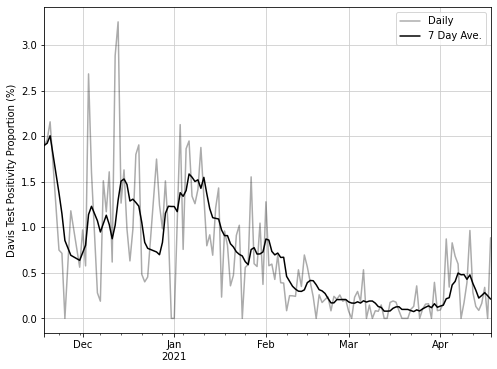

In [389]:
plt.rcParams["figure.figsize"] = (8,6)
(100*davis_large['pos_rate']).plot(alpha = .33, label='Daily')
(100*davis_large['pos_rate_7dav']).plot(label='7 Day Ave.')
plt.ylabel('Davis Test Positivity Proportion (%)')
plt.xlabel('')
plt.legend()
plt.savefig('../figs/davis_pos_prop_large.png')

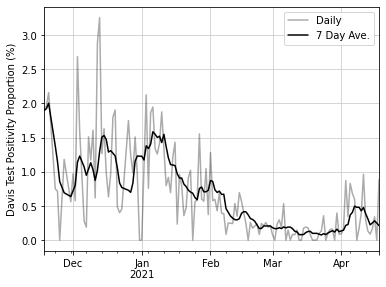

In [388]:
plt.rcParams["figure.figsize"] = (6,4.5)
(100*davis_large['pos_rate']).plot(alpha = .33, label='Daily')
(100*davis_large['pos_rate_7dav']).plot(label='7 Day Ave.')
plt.ylabel('Davis Test Positivity Proportion (%)')
plt.xlabel('')
plt.legend()
plt.savefig('../figs/davis_pos_prop_med.png')

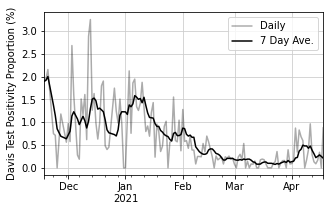

In [390]:
plt.rcParams["figure.figsize"] = (5,3)
(100*davis_large['pos_rate']).plot(alpha = .33, label='Daily')
(100*davis_large['pos_rate_7dav']).plot(label='7 Day Ave.')
plt.ylabel('Davis Test Positivity Proportion (%)')
plt.xlabel('')
plt.legend()
plt.savefig('../figs/davis_pos_prop_small.png')

In [343]:
davis_daily = davis_data.groupby('Date').sum()[['positive','negative']]
yolo_daily = yolo_data.groupby('Date').sum()[['positive','negative']]

In [346]:
davis_daily = davis_daily.reindex(date_idx,fill_value=0)
yolo_daily = yolo_daily.reindex(date_idx,fill_value=0)

In [347]:
davis_daily = proc_daily_df(davis_daily)
yolo_daily = proc_daily_df(yolo_daily)

In [348]:
davis_daily = davis_daily.reindex(small_date_idx,fill_value=0)
yolo_daily = yolo_daily.reindex(small_date_idx,fill_value=0)

In [353]:
campus_data = pd.read_csv('../data/20210427_covid_test_data.csv')

In [354]:
campus_data['positive'] = campus_data['Result'] == 'Detected'
campus_data['negative'] = campus_data['Result'] == 'Not Detected'

In [355]:
campus_data['Date'] = pd.PeriodIndex(campus_data['CollectionDate'], freq='D')

In [356]:
campus_daily = campus_data.groupby('Date').sum()[['positive','negative']]
campus_daily = campus_daily.reindex(date_idx,fill_value=0)
campus_daily = proc_daily_df(campus_daily)

In [358]:
campus_daily = campus_daily.reindex(small_date_idx)

In [361]:
for df in [davis_daily, yolo_daily, CA_daily, campus_daily]:
    df['pos_perc_7dav'] = df['pos_rate_7dav'] * 100

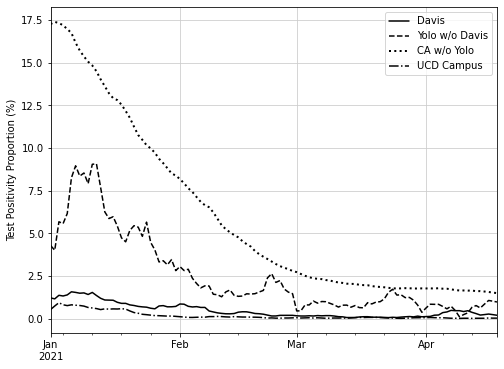

In [394]:
plt.rcParams["figure.figsize"] = (8,6)
davis_daily['pos_perc_7dav'].plot(label='Davis')
yolo_daily['pos_perc_7dav'].plot(label='Yolo w/o Davis',linestyle='dashed')
CA_daily['pos_perc_7dav'].plot(label='CA w/o Yolo',linestyle='dotted',linewidth=2)
campus_daily['pos_perc_7dav'].plot(label='UCD Campus',linestyle='dashdot')
plt.ylabel('Test Positivity Proportion (%)')
plt.legend()
plt.savefig('../figs/pos_prop_large.png')

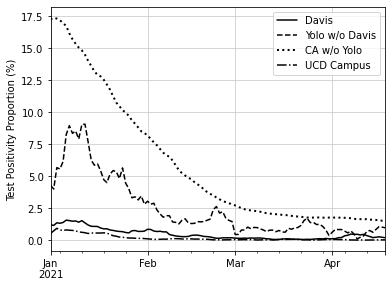

In [395]:
plt.rcParams["figure.figsize"] = (6,4.5)
davis_daily['pos_perc_7dav'].plot(label='Davis')
yolo_daily['pos_perc_7dav'].plot(label='Yolo w/o Davis',linestyle='dashed')
CA_daily['pos_perc_7dav'].plot(label='CA w/o Yolo',linestyle='dotted',linewidth=2)
campus_daily['pos_perc_7dav'].plot(label='UCD Campus',linestyle='dashdot')
plt.ylabel('Test Positivity Proportion (%)')
plt.legend()
plt.savefig('../figs/pos_prop_med.png')

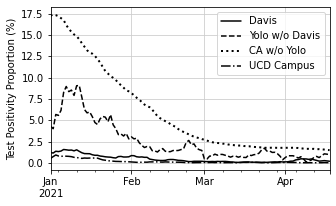

In [396]:
plt.rcParams["figure.figsize"] = (5,3)
davis_daily['pos_perc_7dav'].plot(label='Davis')
yolo_daily['pos_perc_7dav'].plot(label='Yolo w/o Davis',linestyle='dashed')
CA_daily['pos_perc_7dav'].plot(label='CA w/o Yolo',linestyle='dotted',linewidth=2)
campus_daily['pos_perc_7dav'].plot(label='UCD Campus',linestyle='dashdot')
plt.ylabel('Test Positivity Proportion (%)')
plt.legend()
plt.savefig('../figs/pos_prop_small.png')

In [170]:
latest = yolo_daily.index.max()

In [285]:
CA_data.index

PeriodIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
             '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
             '2020-01-10', '2020-01-11',
             ...
             '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15',
             '2021-04-16', '2021-04-17', '2021-04-18', '2021-04-19',
             '2021-04-20', '2021-04-21'],
            dtype='period[D]', name='date', length=463, freq='D')

In [286]:
CA_data['date'] = pd.PeriodIndex(CA_data.reset_index()['date'], freq='D')

In [287]:
CA_data = CA_data.set_index('date')

In [291]:
davis_daily.loc['2021-1-1':]

,positive,negative,total,positive_7dav,negative_7dav,total_7dav,pos_rate,pos_rate_7dav
2021-01-01,0,1,1,6.428571,547.142857,553.571429,0.000000,0.011613
2021-01-02,4,344,348,6.142857,550.428571,556.571429,0.011494,0.011037
2021-01-03,20,955,975,7.857143,591.571429,599.428571,0.020513,0.013108
2021-01-04,7,983,990,7.428571,569.857143,577.285714,0.007071,0.012868
2021-01-05,16,799,815,7.714286,534.428571,542.142857,0.019632,0.014229
...,...,...,...,...,...,...,...,...
2021-04-14,1,876,877,1.571429,709.428571,711.000000,0.001140,0.002210
2021-04-15,2,950,952,1.857143,717.428571,719.285714,0.002101,0.002582
2021-04-16,2,931,933,2.000000,718.142857,720.142857,0.002144,0.002777
2021-04-17,0,460,460,1.714286,727.714286,729.428571,0.000000,0.002350


In [399]:
comb_daily = pd.DataFrame({'davis_hdt':davis_daily.loc['2021-1-1':,'pos_rate_7dav'],
    'yolo_hdt': yolo_daily.loc['2021-1-1':,'pos_rate_7dav'],
    'ca_cdph': CA_daily.loc['2021-1-1':,'pos_rate_7dav'],
    'campus': campus_daily.loc['2021-1-1':,'pos_rate_7dav']})

In [400]:
comb_daily.reset_index().to_csv('../data/comb_daily_7dav.csv',index=False)

In [14]:
davis_data = hdt_data[hdt_data['CBG'].isin(Davis_CBG)]

In [15]:
yolo_hdt_data = hdt_data[hdt_data['County'] == 'Yolo']

In [16]:
davis_daily = davis_data.groupby('Date').sum()[['positive','negative']]

In [17]:
hdt_daily = hdt_daily.join(hdt_daily.rolling('7D').mean(),rsuffix='_7dav')
hdt_daily['pos_rate'] = hdt_daily.eval('positive / (positive + negative)')
hdt_daily['pos_rate_7dav'] = hdt_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [18]:
davis_daily = davis_daily.join(davis_daily.rolling('7D').mean(),rsuffix='_7dav')
davis_daily['pos_rate'] = davis_daily.eval('positive / (positive + negative)')
davis_daily['pos_rate_7dav'] = davis_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [19]:
ca_daily = test_data.groupby('lab_result_date').sum().rename(columns={'pos_results':'positive', 'neg_results':'negative'})

In [20]:
ca_daily = ca_daily.join(ca_daily.rolling('7D').mean(),rsuffix='_7dav')
ca_daily['pos_rate'] = ca_daily.eval('positive / (positive + negative)')
ca_daily['pos_rate_7dav'] = ca_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [21]:
yolo_daily = test_data.query('FIPS=="06113"')

In [22]:
yolo_daily = yolo_daily.groupby('lab_result_date').sum().rename(columns={'pos_results':'positive', 'neg_results':'negative'})

In [23]:
yolo_daily = yolo_daily.join(yolo_daily.rolling('7D').mean(),rsuffix='_7dav')
yolo_daily['pos_rate'] = yolo_daily.eval('positive / (positive + negative)')
yolo_daily['pos_rate_7dav'] = yolo_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [24]:
yolo_daily = yolo_daily.reset_index().rename(columns={'lab_result_date':'Date'})
ca_daily = ca_daily.reset_index().rename(columns={'lab_result_date':'Date'})

In [25]:
hdt_daily.reset_index(inplace=True)
davis_daily.reset_index(inplace=True)

Text(0, 0.5, 'Pos PPT')

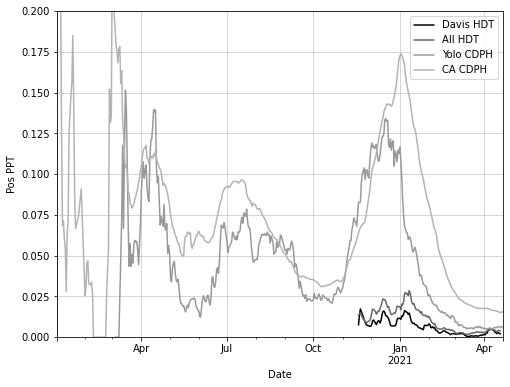

In [29]:
plt.style.use('./greygrid.mplstyle')
ax = davis_daily.plot('Date','pos_rate_7dav',label='Davis HDT')
hdt_daily.plot('Date','pos_rate_7dav', ax=ax, label='All HDT')
yolo_daily.plot('Date','pos_rate_7dav', ax=ax, label='Yolo CDPH')
ca_daily.plot('Date','pos_rate_7dav', ax=ax, label='CA CDPH')
plt.ylim([0,.2])
plt.ylabel('Pos PPT')

In [29]:
yolo_daily['total_7dav'] = yolo_daily.eval('positive_7dav + negative_7dav')
yolo_daily['total'] = yolo_daily.eval('positive + negative')

<AxesSubplot:xlabel='Date'>

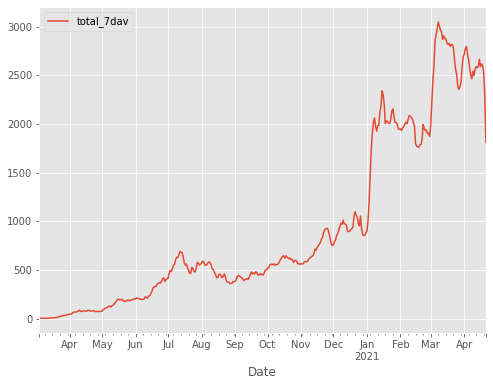

In [30]:
yolo_daily.plot('Date','total_7dav')

In [31]:
yolo_hdt_daily = yolo_hdt_data.groupby('Date').sum()[['positive','negative']]
yolo_hdt_daily = yolo_hdt_daily.join(yolo_hdt_daily.rolling('7D').mean(),rsuffix='_7dav')

In [32]:
yolo_hdt_daily['total'] = yolo_hdt_daily.eval('positive + negative')
yolo_hdt_daily['total_7dav'] = yolo_hdt_daily.eval('positive_7dav + negative_7dav')

In [33]:
yolo_hdt_daily.reset_index(inplace=True)

/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fd8773f6550> has a label of '_nolegend_' which cannot be automatically added to the legend.
/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fd87743e640> has a label of '_nolegend_' which cannot be automatically added to the legend.


Text(0, 0.5, 'Total tests')

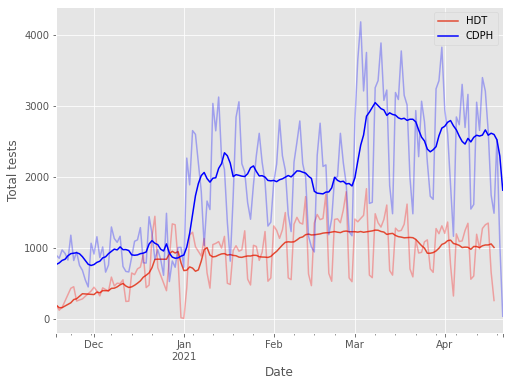

In [34]:
ax = yolo_hdt_daily.plot('Date','total_7dav',label='HDT')
yolo_hdt_daily.plot('Date','total',ax=ax,color='r',alpha=.3,label="_nolegend_")
yolo_daily.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total_7dav', ax=ax,label='CDPH',color='b')
yolo_daily.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total', ax=ax, label="_nolegend_",color='b',alpha=.3)
plt.ylabel('Total tests')

In [35]:
yolo_corr = yolo_daily[['Date','positive','negative']].copy()

In [36]:
yolo_corr = yolo_corr.set_index('Date')

In [37]:
yolo_hdt_daily = yolo_hdt_daily.set_index('Date')

In [38]:
yolo_corr['negative'] = yolo_corr['negative'].copy()\
    .add(yolo_hdt_daily.loc[:'2021-1-1','negative'], fill_value=0)

In [39]:
yolo_corr = yolo_corr.join(yolo_corr.rolling('7D').mean(),rsuffix='_7dav')
yolo_corr['pos_rate'] = yolo_corr.eval('positive / (positive + negative)')
yolo_corr['pos_rate_7dav'] = yolo_corr.eval('positive_7dav / (positive_7dav + negative_7dav)')

In [40]:
yolo_corr

,positive,negative,positive_7dav,negative_7dav,pos_rate,pos_rate_7dav
Date,,,,,,
2020-03-04,0,3.0,0.000000,3.000000,0.000000,0.000000
2020-03-05,0,4.0,0.000000,3.500000,0.000000,0.000000
2020-03-07,0,1.0,0.000000,2.666667,0.000000,0.000000
2020-03-08,0,4.0,0.000000,3.000000,0.000000,0.000000
2020-03-11,1,4.0,0.250000,3.250000,0.200000,0.071429
...,...,...,...,...,...,...
2021-04-17,17,1727.0,16.571429,2600.714286,0.009748,0.006332
2021-04-18,14,1473.0,16.000000,2583.571429,0.009415,0.006155
2021-04-19,13,2516.0,15.714286,2508.714286,0.005140,0.006225


In [41]:
yolo_corr['total'] = yolo_corr.eval('positive + negative')
yolo_corr['total_7dav'] = yolo_corr.eval('positive_7dav + negative_7dav')

In [42]:
yolo_corr.reset_index(inplace=True)
yolo_hdt_daily.reset_index(inplace=True)

/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fd8774a8940> has a label of '_nolegend_' which cannot be automatically added to the legend.
/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fd8774fbf70> has a label of '_nolegend_' which cannot be automatically added to the legend.
/home/jsharpna/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fd8774d1610> has a label of '_nolegend_' which cannot be automatically added to the legend.


Text(0, 0.5, 'Total tests')

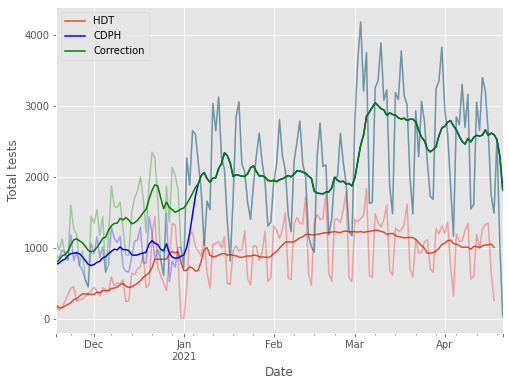

In [43]:
ax = yolo_hdt_daily.plot('Date','total_7dav',label='HDT')
yolo_hdt_daily.plot('Date','total',ax=ax,color='r',alpha=.3,label="_nolegend_")
yolo_daily.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total_7dav', ax=ax,label='CDPH',color='b')
yolo_daily.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total', ax=ax, label="_nolegend_",color='b',alpha=.3)
yolo_corr.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total_7dav', ax=ax,label='Correction',color='g')
yolo_corr.query('Date >= "{}"'.format(yolo_hdt_daily['Date'].min())).plot('Date','total', ax=ax, label="_nolegend_",color='g',alpha=.3)
plt.ylabel('Total tests')

Text(0, 0.5, 'Pos PPT')

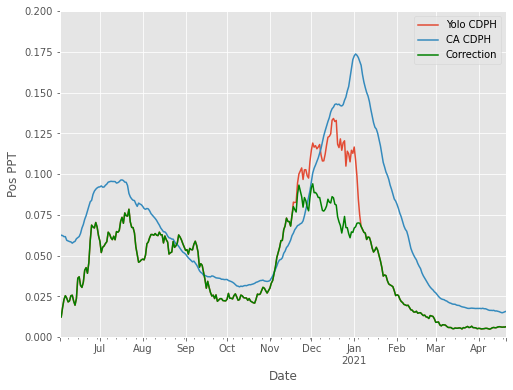

In [44]:
ax = yolo_daily.query('Date > "2020-6-1"').plot('Date','pos_rate_7dav', label='Yolo CDPH')
ca_daily.query('Date > "2020-6-1"').plot('Date','pos_rate_7dav', ax=ax, label='CA CDPH')
yolo_corr.query('Date > "2020-6-1"').plot('Date','pos_rate_7dav', ax=ax, label='Correction', color='g')
plt.ylim([0,.2])
plt.ylabel('Pos PPT')

In [45]:
hdt_first = hdt_data.groupby('pseudo_ID').apply(lambda df: df.iloc[0,:])
hdt_first = hdt_first[hdt_first['County'] == 'Yolo']

In [46]:
hdt_first_davis = hdt_first[hdt_first['CBG'].isin(Davis_CBG)]

In [47]:
hdt_first_daily = hdt_first.groupby('Date').sum()[['positive','negative']]

In [48]:
hdt_first_davis_daily = hdt_first_davis.groupby('Date').sum()[['positive','negative']]

In [49]:
def proc_daily_df(hdt_daily):
    hdt_daily['total'] = hdt_daily.eval('positive + negative')
    hdt_daily = hdt_daily.join(hdt_daily.rolling('7D').mean(),rsuffix='_7dav')
    hdt_daily['pos_rate'] = hdt_daily.eval('positive / (positive + negative)')
    hdt_daily['pos_rate_7dav'] = hdt_daily.eval('positive_7dav / (positive_7dav + negative_7dav)')
    return hdt_daily

In [50]:
hdt_first_daily = proc_daily_df(hdt_first_daily)

In [51]:
hdt_first_davis_daily = proc_daily_df(hdt_first_davis_daily)

In [52]:
hdt_first_daily = hdt_first_daily.reset_index()

In [53]:
hdt_first_davis_daily = hdt_first_davis_daily.reset_index()

Text(0, 0.5, 'Pos PPT')

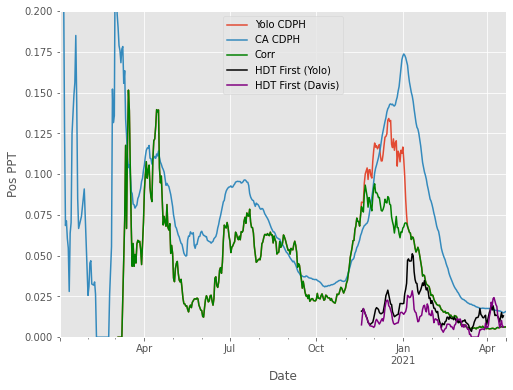

In [54]:
ax = yolo_daily.plot('Date','pos_rate_7dav', label='Yolo CDPH')
ca_daily.plot('Date','pos_rate_7dav', ax=ax, label='CA CDPH')
yolo_corr.plot('Date','pos_rate_7dav', ax=ax, label='Corr', color='g')
hdt_first_daily.plot('Date','pos_rate_7dav', ax=ax, label='HDT First (Yolo)', color='k')
hdt_first_davis_daily.plot('Date','pos_rate_7dav', ax=ax, label='HDT First (Davis)', color='purple')
plt.ylim([0,.2])
plt.ylabel('Pos PPT')

In [55]:
yolo_first_corr = yolo_daily[['Date','positive','negative']].copy()

In [56]:
yolo_first_corr = yolo_first_corr.set_index('Date')

In [57]:
hdt_first_daily = hdt_first_daily.set_index('Date')

In [58]:
yolo_first_corr['negative'] = yolo_first_corr['negative'].copy()\
    .add(hdt_first_daily.loc[:'2021-1-1','negative'], fill_value=0)

In [59]:
yolo_first_corr = proc_daily_df(yolo_first_corr)

In [60]:
yolo_corr['total'] = yolo_corr.eval('positive + negative')
yolo_corr['total_7dav'] = yolo_corr.eval('positive_7dav + negative_7dav')

In [61]:
yolo_first_corr.reset_index(inplace=True)
hdt_first_daily.reset_index(inplace=True)

Text(0, 0.5, 'Pos PPT')

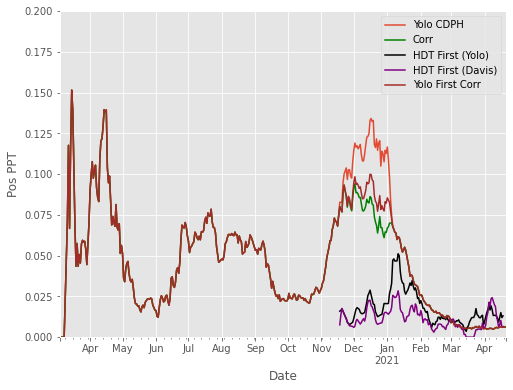

In [62]:
ax = yolo_daily.plot('Date','pos_rate_7dav', label='Yolo CDPH')
yolo_corr.plot('Date','pos_rate_7dav', ax=ax, label='Corr', color='g')
hdt_first_daily.plot('Date','pos_rate_7dav', ax=ax, label='HDT First (Yolo)', color='k')
hdt_first_davis_daily.plot('Date','pos_rate_7dav', ax=ax, label='HDT First (Davis)', color='purple')
yolo_first_corr.plot('Date','pos_rate_7dav', ax=ax, label='Yolo First Corr', color='brown')
plt.ylim([0,.2])
plt.ylabel('Pos PPT')

In [64]:
alameda_daily = test_data.query('FIPS=="06001"')

In [67]:
alameda_daily = alameda_daily.groupby('lab_result_date').sum().rename(columns={'pos_results':'positive', 'neg_results':'negative'})

In [68]:
alameda_daily = proc_daily_df(alameda_daily)

In [73]:
alameda_daily = alameda_daily.reset_index()

In [74]:
alameda_daily['Date'] = pd.PeriodIndex(alameda_daily['lab_result_date'])

Text(0, 0.5, 'Pos PPT')

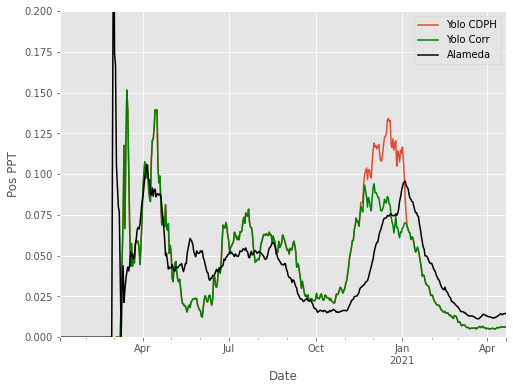

In [76]:
ax = yolo_daily.plot('Date','pos_rate_7dav', label='Yolo CDPH')
yolo_corr.plot('Date','pos_rate_7dav', ax=ax, label='Yolo Corr', color='g')
alameda_daily.plot('Date','pos_rate_7dav', ax=ax, label='Alameda', color='k')
plt.ylim([0,.2])
plt.ylabel('Pos PPT')

In [77]:
test_data

,lab_result_date,county,FIPS,pos_results,neg_results,pos_rate
0,2020-01-02,San Diego,06073,0,1,0.000000
1,2020-01-03,Los Angeles,06037,0,2,0.000000
2,2020-01-03,Riverside,06065,2,0,1.000000
3,2020-01-03,Sacramento,06067,4,2,0.666667
4,2020-01-04,Alameda,06001,0,1,0.000000
...,...,...,...,...,...,...
23535,2021-04-21,Tulare,06107,1,74,0.013333
23536,2021-04-21,Tuolumne,06109,0,4,0.000000
23537,2021-04-21,Ventura,06111,1,195,0.005102
23538,2021-04-21,Yolo,06113,0,31,0.000000


In [83]:
dec_data = test_data.set_index('lab_result_date')['2020-12-1':'2021-1-1'].groupby('county').sum()

In [85]:
week_data = pd.read_csv('../data/week_sum_demo.csv',dtype={'FIPS':str})

In [87]:
pop = week_data.groupby('FIPS').mean()['total_pop']

In [92]:
week_data

,FIPS,week,pos_results,days_by_10kpop,youth,seniors,hispanic_pop,black_pop,asian_pop,pov_prop,bac_prop,total_pop
0,06001,2020-04-27/2020-05-03,68.0,334.2658,0.284829,0.142858,0.223209,0.128276,0.355406,0.726566,0.429647,1671329.0
1,06001,2020-05-04/2020-05-10,342.0,1169.9303,0.284829,0.142858,0.223209,0.128276,0.355406,0.726566,0.429647,1671329.0
2,06001,2020-05-11/2020-05-17,362.0,1169.9303,0.284829,0.142858,0.223209,0.128276,0.355406,0.726566,0.429647,1671329.0
3,06001,2020-05-18/2020-05-24,674.0,1169.9303,0.284829,0.142858,0.223209,0.128276,0.355406,0.726566,0.429647,1671329.0
4,06001,2020-05-25/2020-05-31,642.0,1169.9303,0.284829,0.142858,0.223209,0.128276,0.355406,0.726566,0.429647,1671329.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2547,06115,2021-01-25/2021-01-31,178.0,55.0676,0.367837,0.130549,0.291415,0.064702,0.094765,0.540348,0.143537,78668.0
2548,06115,2021-02-01/2021-02-07,140.0,55.0676,0.367837,0.130549,0.291415,0.064702,0.094765,0.540348,0.143537,78668.0
2549,06115,2021-02-08/2021-02-14,105.0,55.0676,0.367837,0.130549,0.291415,0.064702,0.094765,0.540348,0.143537,78668.0
2550,06115,2021-02-15/2021-02-21,97.0,55.0676,0.367837,0.130549,0.291415,0.064702,0.094765,0.540348,0.143537,78668.0
